# A two-dimensional (surface) polymerase

## Setup

- A micron-long domain divided up into 37~ subdomains the width of an actin monomer (2.7 nm)
- A barbed end starting in the first subdomain
- An NPF every 10 subdomains
- A solution elongation rate constant equal to $11\ \mathrm{\mu M^{-1} s^{-1}}$
- An actin loading rate constant equal to $5.0\ \mathrm{\mu M^{-1} s^{-1}}$. The constant gets corrected by a factor that is the cubic root of the molecular-weight ratio.
- A dissociation rate constant equal to $3.0\ \mathrm{s^{-1}}$
- A monomer diffusion coefficient equal to $1.0\ \mathrm{\mu m^2 s^{-1}}$
- A Gillespie algorithm to simulate barbed-end elongation and explicit of monomers unbinding from NPF sites

In [1]:
from numpy import arange, hstack, log, array, full, cumsum, searchsorted, unravel_index, logical_and, zeros, exp, meshgrid, array, sqrt
from numpy.random import rand, choice
from numba import jit
%load_ext line_profiler

In [2]:
@jit(nopython=True)
def numba_cumsum(row):
    return row.cumsum()

@jit(nopython=True)
def numba_search(row, x):
    return searchsorted(row, x)

@jit(nopython=True)
def numba_nonzero(mat):
    return mat.nonzero()

In [3]:
def simulate_2d_polymerase(no_domains = 370, npf_spacing = 10, actin_conc = 5.0):
    monomer_count_mat = zeros((no_domains, no_domains), dtype = int)
    has_npf_mat = zeros((no_domains, no_domains), dtype = bool)
    row_mat, col_mat = meshgrid(arange(0, no_domains, npf_spacing), arange(0, no_domains, npf_spacing))
    has_npf_mat[row_mat, col_mat] = True
    is_npf_loaded_mat = zeros((no_domains, no_domains), dtype = bool)
    current_time = 0.0
    total_time = 20.0
    time_row = array([0.0])
    no_loaded_npf_row = array([0])
    transition_bin_row = cumsum([0, no_domains, no_domains, no_domains])
    end_position = array([0, 0])
    end_orientation = sqrt(2) / 2 * array([1, 1])
    no_monomers = 0
    transition_rate_mat = zeros((no_domains, no_domains * 3))
    while current_time <= total_time:
        transition_rate_mat[:, :no_domains][logical_and(has_npf_mat, is_npf_loaded_mat == False)] = 5.0 * actin_conc * (42 / (42 + 8))**(1/3)
        transition_rate_mat[:, no_domains:(2 * no_domains)][logical_and(has_npf_mat, is_npf_loaded_mat == True)] = 3.0
        transition_rate_mat[:, (2 * no_domains):] = 1.0 / 2.7e-3 * monomer_count_mat
        #transition_rate_mat = hstack((loading_rate_mat, unloading_rate_mat, diffusion_rate_mat))
        nonzero_rate_row_mat, nonzero_rate_col_mat = numba_nonzero(transition_rate_mat)
        nonzero_rate_cumsum = numba_cumsum(hstack((0, transition_rate_mat[nonzero_rate_row_mat, nonzero_rate_col_mat].flatten())))
        index_nonzero_transition = numba_search(nonzero_rate_cumsum > nonzero_rate_cumsum[-1] * rand(), True) - 1
        transition_row = nonzero_rate_row_mat[index_nonzero_transition]
        transition_col = nonzero_rate_col_mat[index_nonzero_transition]
        index_transition = searchsorted(transition_bin_row > transition_col, True) - 1
        rel_transition_col = transition_col - transition_bin_row[index_transition]
        if index_transition == 2:
            monomer_count_mat[transition_row, rel_transition_col] -= 1
            direction = choice(4)
            if direction == 0:
                if rel_transition_col < (no_domains - 1):
                    monomer_count_mat[transition_row, rel_transition_col + 1] += 1
            elif direction == 1:
                if transition_row > 0:
                    monomer_count_mat[transition_row - 1, rel_transition_col] += 1
            elif direction == 2:
                if rel_transition_col > 0:
                    monomer_count_mat[transition_row, rel_transition_col - 1] += 1
            elif transition_row < (no_domains - 1):
                monomer_count_mat[transition_row + 1, rel_transition_col] += 1
        elif index_transition == 1:
            is_npf_loaded_mat[transition_row, rel_transition_col] = False
            monomer_count_mat[transition_row, rel_transition_col] += 1
        else:
            is_npf_loaded_mat[transition_row, rel_transition_col] = True
        
        time_interval = -log(rand()) / nonzero_rate_cumsum[-1]
        current_time += time_interval
        # Check if barbed end is near a monomer.
        if (end_position < no_domains).all():
            if monomer_count_mat[end_position[0] + 1, end_position[1] + 1] > 0:
                monomer_count_mat[end_position[0] + 1, end_position[1] + 1] -= 1
                end_position += 1
                no_monomers += 1
            if exp(- 11.0 * actin_conc * time_interval) < rand():
                end_position += 1
        time_row = hstack((time_row, current_time))
        # From solution.
        no_loaded_npf_row = hstack((no_loaded_npf_row, is_npf_loaded_mat.sum()))
    print(end_position)
    print(no_monomers)
    return no_loaded_npf_row, time_row, monomer_count_mat

In [4]:
%lprun -f simulate_2d_polymerase no_loaded_npf_row, time_row, monomer_count_row = simulate_2d_polymerase()

*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-06 s

Total time: 67503.8 s
File: <ipython-input-3-1cd40c602b8c>
Function: simulate_2d_polymerase at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def simulate_2d_polymerase(no_domains = 370, npf_spacing = 10, actin_conc = 5.0):
     2         1        216.0    216.0      0.0      monomer_count_mat = zeros((no_domains, no_domains), dtype = int)
     3         1        213.0    213.0      0.0      has_npf_mat = zeros((no_domains, no_domains), dtype = bool)
     4         1        452.0    452.0      0.0      row_mat, col_mat = meshgrid(arange(0, no_domains, npf_spacing), arange(0, no_domains, npf_spacing))
     5         1        106.0    106.0      0.0      has_npf_mat[row_mat, col_mat] = True
     6         1        211.0    211.0      0.0      is_npf_loaded_mat = zeros((no_domains, no_domains), dtype = bool)
     7         1          5.0      5.0      0.0      current_time = 0.0
     8         1 

NameError: name 'time_row' is not defined

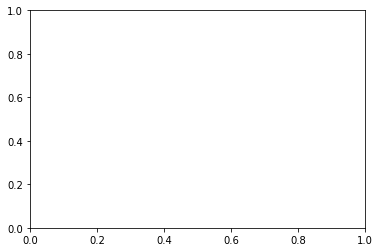

In [5]:
from matplotlib.pyplot import subplots
figure_hand, axes_hand = subplots()
axes_hand.plot(time_row, no_loaded_npf_row)